In [11]:
import torch
import torch.nn as nn
import time
import argparse
import numpy as np
from pandas import DataFrame
import torch.nn.functional as F

# Device configuration
print(torch.__version__)

1.4.0


In [12]:
def generate(name):
    # If you what to replicate the DeepLog paper results(Actually, I have a better result than DeepLog paper results),
    # you should use the 'list' not 'set' to obtain the full dataset, I use 'set' just for test and acceleration.
    hdfs = set()
    # hdfs = []
    with open('data/' + name, 'r') as f:
        for ln in f.readlines():
            ln = list(map(lambda n: n - 1, map(int, ln.strip().split())))
            ln = ln + [-1] * (window_size + 1 - len(ln))
            hdfs.add(tuple(ln))
            # hdfs.append(tuple(ln))
    print('Number of sessions({}): {}'.format(name, len(hdfs)))
    return hdfs

In [13]:
class DL(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(DL, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

        size = 0
        for p in self.parameters():
            size += p.nelement()
        print('Total param size: {}'.format(size))

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class Att(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(Att, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

        size = 0
        for p in self.parameters():
          size += p.nelement()
        print('Total param size: {}'.format(size))

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (final_hidden_state, final_cell_state) = self.lstm(x, (h0, c0))
        final_hidden_state = final_hidden_state[-1]
        out, att_weight = self.attention_net(out, final_hidden_state)
        out = self.fc(out)
        return out, att_weight

    def attention_net(self, lstm_output, final_state):

        """ 
        Now we will incorporate Attention mechanism in our LSTM model. In this new model, we will use attention to compute soft alignment score corresponding
        between each of the hidden_state and the last hidden_state of the LSTM. We will be using torch.bmm for the batch matrix multiplication.
        
        Arguments
        ---------
        
        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM
        
        ---------
        
        Returns : It performs attention mechanism by first computing weights for each of the sequence present in lstm_output and and then finally computing the
                  new hidden state.
                  
        Tensor Size :
                    hidden.size() = (batch_size, hidden_size)
                    attn_weights.size() = (batch_size, num_seq)
                    soft_attn_weights.size() = (batch_size, num_seq)
                    new_hidden_state.size() = (batch_size, hidden_size)
                      
        """
        hidden = final_state
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return new_hidden_state, soft_attn_weights

class Train_Att(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(Train_Att, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)
        self.att_w = nn.Parameter(torch.tensor(torch.randn(hidden_size)))
        size = 0
        for p in self.parameters():
            size += p.nelement()
        print('Total param size: {}'.format(size))

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (final_hidden_state, final_cell_state) = self.lstm(x, (h0, c0))
        final_hidden_state = final_hidden_state[-1]
        att_out, att_weights = self.attention_net(out, final_hidden_state)
        out = self.fc(att_out)
        return out, att_weights

    def attention_net(self, lstm_output, final_state):
        batch_size = lstm_output.shape[0]
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(torch.tanh(lstm_output), self.att_w.expand(batch_size, self.att_w.shape[0]).unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        new_hidden_state = torch.tanh(new_hidden_state)
        return new_hidden_state, soft_attn_weights

In [14]:
num_classes = 28
input_size = 1
model_path = 'model/window_size=7'
# parser = argparse.ArgumentParser()
# parser.add_argument('-num_layers', default=2, type=int)
# parser.add_argument('-hidden_size', default=64, type=int)
# parser.add_argument('-window_size', default=10, type=int)
# parser.add_argument('-num_candidates', default=9, type=int)
# args = parser.parse_args()
num_layers = 2
hidden_size = 64
window_size = 7
num_candidates = 3

In [15]:
model_type = 'train_att'
if model_type == 'dl':
    model = DL(input_size, hidden_size, num_layers, num_classes)
elif model_type == 'att':
    model = Att(input_size, hidden_size, num_layers, num_classes)
elif model_type == 'train_att':
    model = Train_Att(input_size, hidden_size, num_layers, num_classes)
        
model_path = model_path + '_' + model_type + '.pt'
check = torch.load(model_path, map_location=lambda storage, loc: storage)

model.load_state_dict(check)
model.eval()
print('model_path: {}'.format(model_path))
test_normal_loader = generate('hdfs_test_normal')
test_abnormal_loader = generate('hdfs_test_abnormal')
TP = 0
FP = 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Total param size: 52316
model_path: model/window_size=7_train_att.pt
Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


In [ ]:
# Test the model
with torch.no_grad():
    for index, line in enumerate(test_normal_loader):
        if index % 2000 == 0:
            print(chr(27) + "[2J")
            print(str(index/len(test_normal_loader) * 100)+'%')
        for i in range(len(line) - window_size):
            seq = line[i:i + window_size]
            label = line[i + window_size]
            seq = torch.tensor(seq, dtype=torch.float).view(-1, window_size, input_size)
            label = torch.tensor(label).view(-1)
            output, _ = model(seq)
            predicted = torch.argsort(output, 1)[0][-num_candidates:]
            if label not in predicted:
                FP += 1
                break
     

In [16]:
seq_list = []
attention_list = []
label_list = []
with torch.no_grad():
    for index, line in enumerate(test_abnormal_loader):
        if index % 2000 == 0:
            print(chr(27) + "[2J")
            print(str(index/len(test_abnormal_loader) * 100)+'%')
        for i in range(len(line) - window_size):
            seq_raw = line[i:i + window_size]
            label_raw = line[i + window_size]
            seq = torch.tensor(seq_raw, dtype=torch.float).view(-1, window_size, input_size)
            label = torch.tensor(label_raw).view(-1)
            output, attention_weights = model(seq)
            predicted = torch.argsort(output, 1)[0][-num_candidates:]
            if label not in predicted:
                TP += 1
                seq_list.append(seq_raw)
                attention_list.append(attention_weights.data.numpy())
                label_list.append(label_raw)
                break


0.0%

48.50836769342712%

97.01673538685424%


In [ ]:
# Compute precision, recall and F1-measure
FN = len(test_abnormal_loader) - TP
P = 100 * TP / (TP + FP)
R = 100 * TP / (TP + FN)
F1 = 2 * P * R / (P + R)
print('false positive (FP): {}, false negative (FN): {}, Precision: {:.3f}%, Recall: {:.3f}%, F1-measure: {:.3f}%'.format(FP, FN, P, R, F1))
print('Finished Predicting')

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


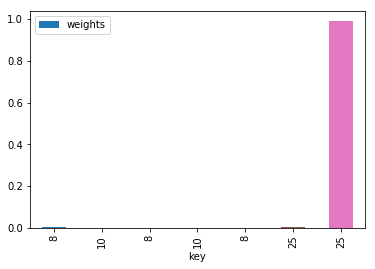

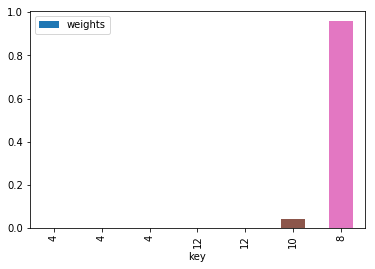

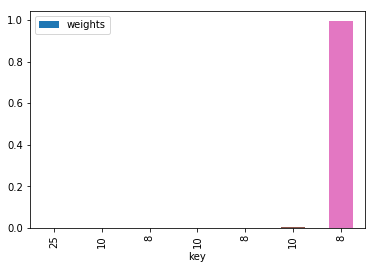

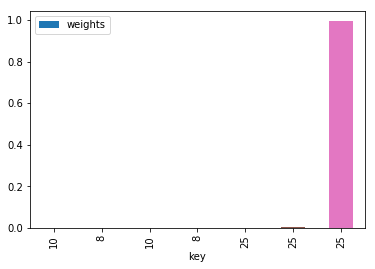

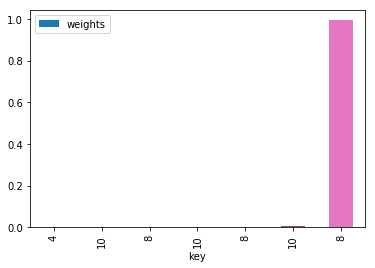

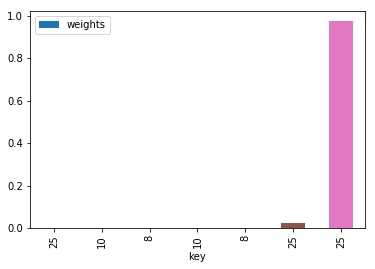

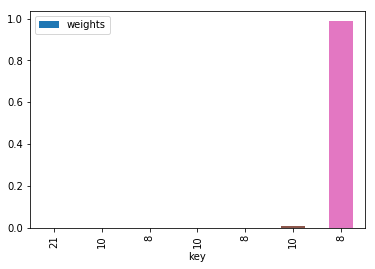

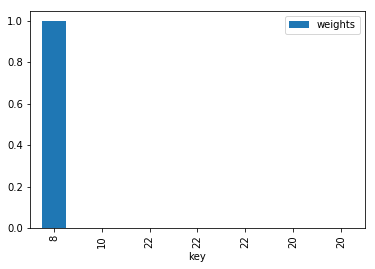

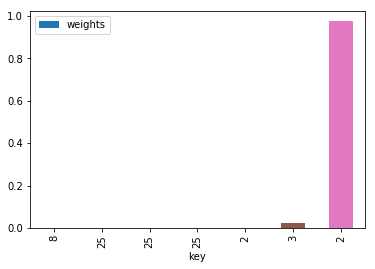

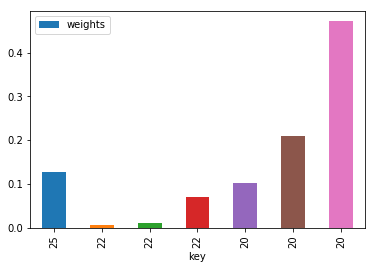

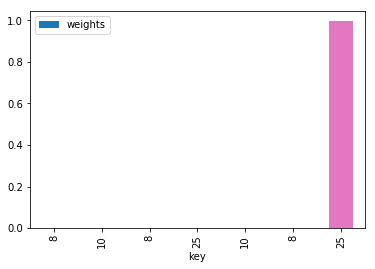

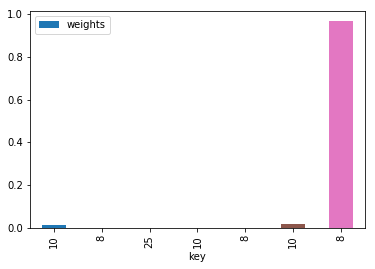

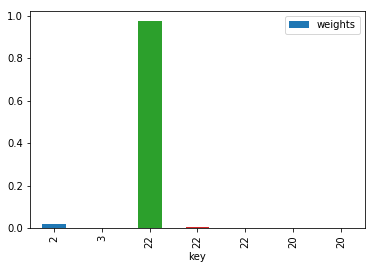

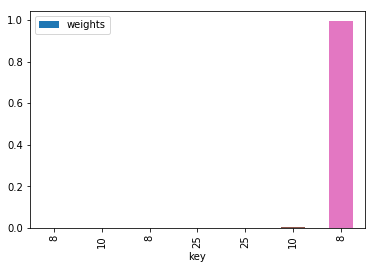

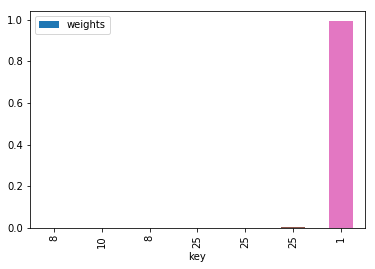

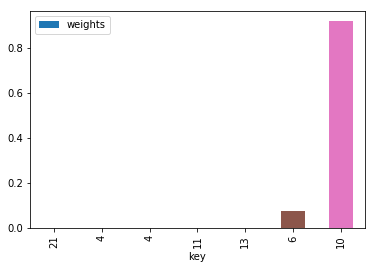

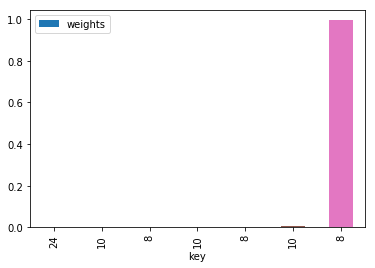

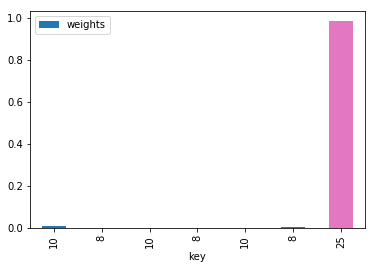

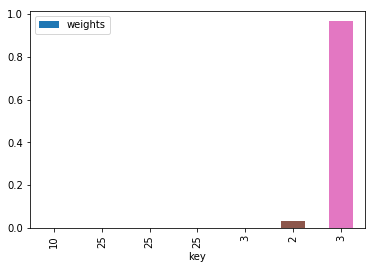

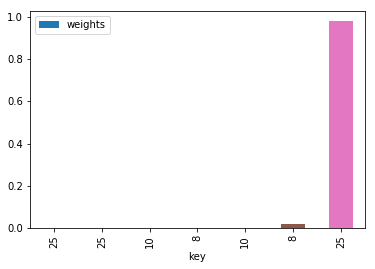

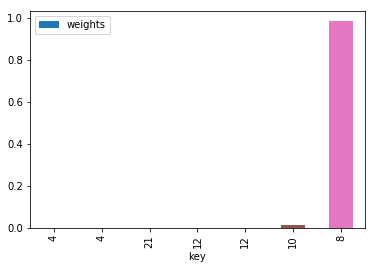

In [17]:
a = []
index = dict()
for i in range(1,41):
    index[seq_list[i*11]] = i*11
for key, value in index.items():
    i = value
    df = DataFrame({'weights':attention_list[value][0], 'key':key})
    a.append(df.plot.bar(x='key', y='weights'))


In [18]:
cases = []
for i, item in enumerate(attention_list):
    for j, value in enumerate(item[0]):
        tenth = item[0][4] 
        if j !=9 and item[0][j]>tenth:
            cases.append(i)
            break
            

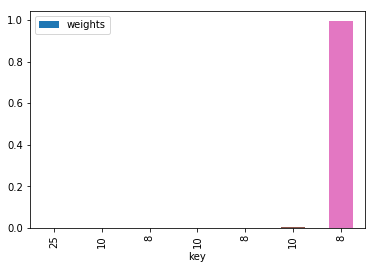

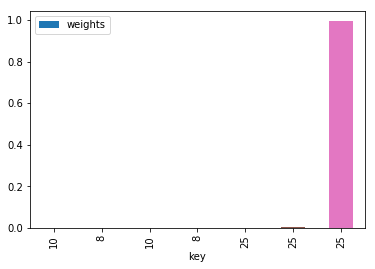

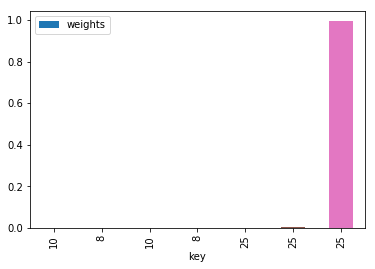

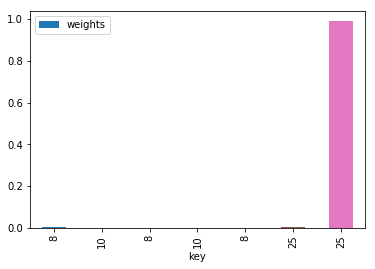

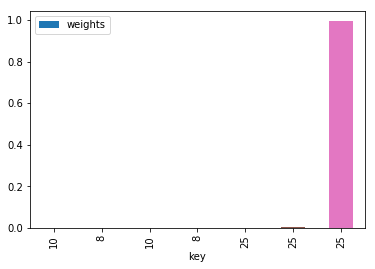

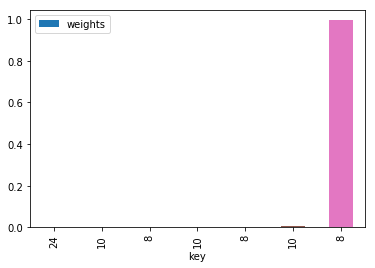

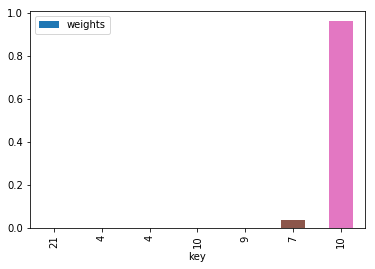

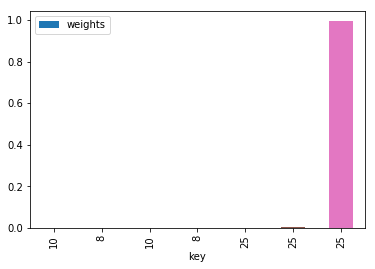

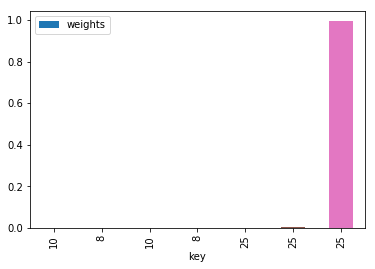

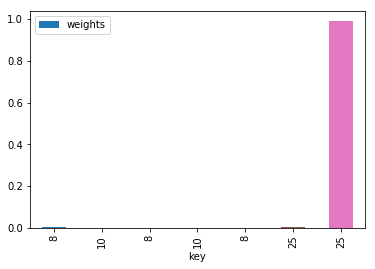

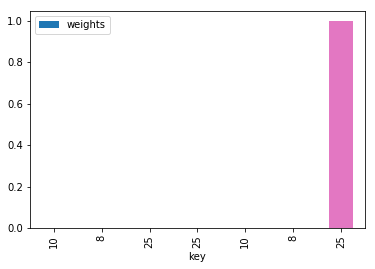

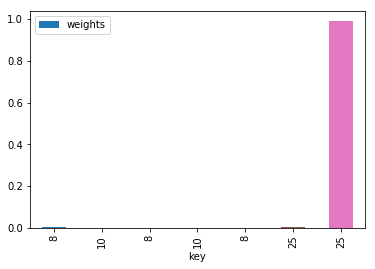

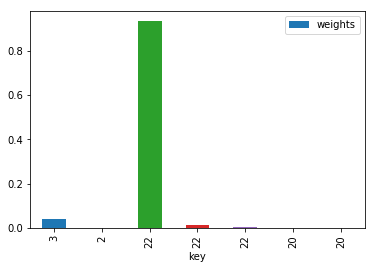

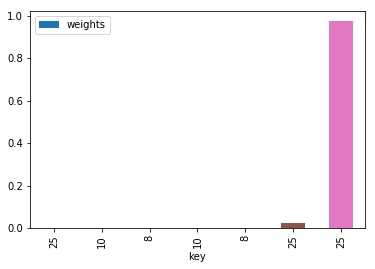

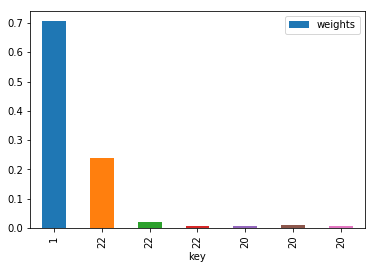

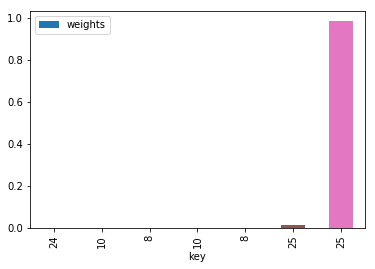

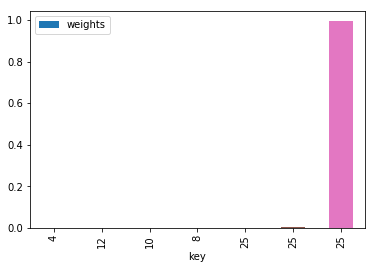

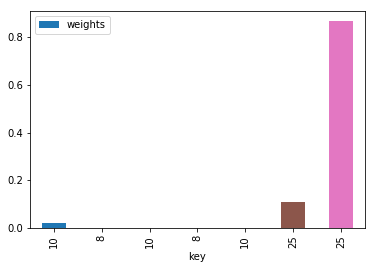

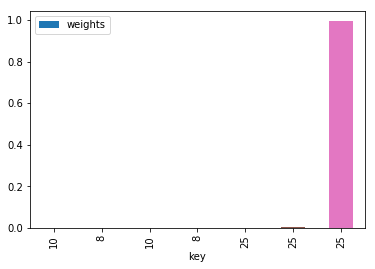

In [19]:
c = []
i=0
for case in cases:
    if i == 19:
        break
    df = DataFrame({'weights':attention_list[case][0], 'key':seq_list[case]})
    c.append(df.plot.bar(x='key', y='weights'))
    i+=1
